In [1]:
#External code comes essentially from my IBM ML course, Pytorch website 
#and various coding forums (including chatGPT) 

In [1]:
# PyTorch Library
import torch 
# PyTorch Neural Network
import torch.nn as nn
# Allows us to transform data
import torchvision.transforms as transforms
# Allows us to get the digit dataset
import torchvision.datasets as dsets
# Creating graphs
import matplotlib.pylab as plt
# Allows us to use arrays to manipulate and store data
import numpy as np
# Memory monitoring
import psutil

import time
# Allows quantization from float32 to 16
import torch.quantization

In [4]:
def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(28, 28), cmap='gray')
    plt.title('y = ' + str(data_sample[1]))

### Download Train and Validation datasets

In [6]:
train_dataset = dsets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
print("Print the training dataset:\n ", train_dataset)

100%|██████████| 9912422/9912422 [00:00<00:00, 88592414.20it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 39063429.16it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 19161946.47it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19948197.66it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Print the training dataset:
  Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [7]:
validation_dataset = dsets.MNIST(root='./data', download=True, train=False,transform=transforms.ToTensor())
print("Print the validation dataset:\n ", validation_dataset)

Print the validation dataset:
  Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()


### Print first image in train and validation

First Image and Label None


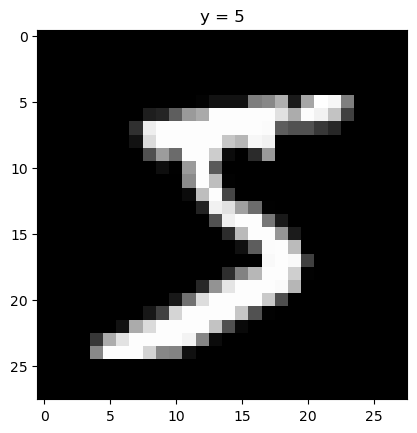

In [9]:
print("First Image and Label", show_data(train_dataset[0]))

In [10]:
print("The label: ", train_dataset[0][1])

The label:  5


First Image and Label None


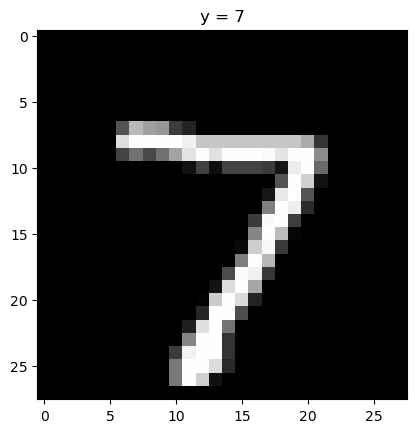

In [8]:
print("First Image and Label", show_data(validation_dataset[0]))

## SoftMax Classifier Model

In [20]:
# Inherits nn.Module which is the base class for all neural networks
class SoftMax(nn.Module):
    
    # Constructor
    def __init__(self, input_size, output_size):
        super(SoftMax, self).__init__()
        # Creates a layer of given input size and output size
        self.linear = nn.Linear(input_size, output_size)
        
    # Prediction
    def forward(self, x):
        # Runs the x value through the single layers defined above
        z = self.linear(x)
        return z

In [10]:
train_dataset[0][0].shape

torch.Size([1, 28, 28])

In [22]:
#input is a 28 * 28 image, output is a probability array for each class
input_dim = 28 * 28
output_dim = 10

### Model Creation

In [21]:
model = SoftMax(input_dim, output_dim)
print("The model:\n ", model)
print('W: ',list(model.parameters())[0].size())
print('b: ',list(model.parameters())[1].size())

The model:
  SoftMax(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)
W:  torch.Size([10, 784])
b:  torch.Size([10])


### Try the model with random weights first

In [13]:
# First we get the X value of the first image
X = train_dataset[0][0]
# We can see the shape is 1 by 28 by 28, we need it to be flattened to 1 by 28 * 28 (784)
print(X.shape)
X = X.view(-1, 28*28)
print(X.shape)
# Now we can make a prediction, each class has a value, and the higher it is the more confident the model is that it is that digit
model(X)

torch.Size([1, 28, 28])
torch.Size([1, 784])


tensor([[ 0.0294, -0.0218, -0.3689, -0.0549, -0.0655, -0.1275,  0.0348, -0.1437,
         -0.1409,  0.2213]], grad_fn=<AddmmBackward0>)

#### Define the learning rate, optimizer, criterion, and data loader

In [23]:
learning_rate = 0.1
# The optimizer will updates the model parameters using the learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# The criterion will measure the loss between the prediction and actual label values
# This is where the SoftMax occurs, it is built into the Criterion Cross Entropy Loss
criterion = nn.CrossEntropyLoss()
# Created a training data loader so we can set the batch size
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
# Created a validation data loader so we can set the batch size
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000)

## Training

In [24]:
n_epochs = 30
# Lists to keep track of loss and accuracy
loss_list = []
accuracy_list = []
speed_list=[]
memory_list=[]
size_list=[]
# Size of the validation data
N_test = len(validation_dataset)

#monitor memory usage
peak_gpu_memory_used =0
cpu_memory_used=0
# Function to train the model based on number of epochs
def train_model(n_epochs):
    # Loops n_epochs times
    for epoch in range(n_epochs):
        start_time = time.time()
        # For each batch in the train loader
        for x, y in train_loader:
            # Resets the calculated gradient value, this must be done each time as it accumulates if we do not reset
            optimizer.zero_grad()
            # Makes a prediction based on the image tensor
            z = model(x.view(-1, 28 * 28))
            # Calculates loss between the model output and actual class
            loss = criterion(z, y)
            # Calculates the gradient value with respect to each weight and bias
            loss.backward()
            # Updates the weight and bias according to calculated gradient value
            optimizer.step()
        
        # Each epoch we check how the model performs with data it has not seen which is the validation data, we are not training here
        correct = 0
        # For each batch in the validation loader
        for x_test, y_test in validation_loader:
            # Makes prediction based on image tensor
            z = model(x_test.view(-1, 28 * 28))
            # Finds the class with the higest output
            _, yhat = torch.max(z.data, 1)
            # Checks if the prediction matches the actual class and increments correct if it does
            correct += (yhat == y_test).sum().item()
        # Calculates the accuracy by dividing correct by size of validation dataset
        accuracy = correct / N_test
        # Keeps track loss
        loss_list.append(loss.data)
        # Keeps track of the accuracy
        accuracy_list.append(accuracy)
        peak_gpu_memory_used= torch.cuda.max_memory_allocated()/ (1024 ** 3)
        cpu_memory_used = psutil.virtual_memory().used / (1024 ** 3)
        end_time = time.time()
        epoch_time = end_time - start_time
        speed_list.append(epoch_time)
        memory_list.append(cpu_memory_used)

        print(f"Epoch {epoch+1}/{n_epochs} - Time: {epoch_time:.2f} seconds")
        print(f"Accuracy : {accuracy}")
        print()
        
#     print(f"Peak GPU Memory Used: {peak_gpu_memory_used:.2f} GB")
    print(f"CPU Memory Used: {cpu_memory_used:.2f} GB")

# Function call
train_model(n_epochs)

Epoch 1/30 - Time: 7.40 seconds
Accuracy : 0.902

Epoch 2/30 - Time: 7.36 seconds
Accuracy : 0.9098

Epoch 3/30 - Time: 7.45 seconds
Accuracy : 0.9134

Epoch 4/30 - Time: 7.53 seconds
Accuracy : 0.9161

Epoch 5/30 - Time: 7.52 seconds
Accuracy : 0.918

Epoch 6/30 - Time: 7.44 seconds
Accuracy : 0.9186

Epoch 7/30 - Time: 7.34 seconds
Accuracy : 0.9192

Epoch 8/30 - Time: 7.40 seconds
Accuracy : 0.9195

Epoch 9/30 - Time: 7.37 seconds
Accuracy : 0.9205

Epoch 10/30 - Time: 7.66 seconds
Accuracy : 0.921

Epoch 11/30 - Time: 7.44 seconds
Accuracy : 0.9211

Epoch 12/30 - Time: 7.32 seconds
Accuracy : 0.9218

Epoch 13/30 - Time: 7.81 seconds
Accuracy : 0.9219

Epoch 14/30 - Time: 7.71 seconds
Accuracy : 0.9219

Epoch 15/30 - Time: 7.86 seconds
Accuracy : 0.922

Epoch 16/30 - Time: 7.75 seconds
Accuracy : 0.9216

Epoch 17/30 - Time: 7.48 seconds
Accuracy : 0.9217

Epoch 18/30 - Time: 7.41 seconds
Accuracy : 0.922

Epoch 19/30 - Time: 7.43 seconds
Accuracy : 0.9224

Epoch 20/30 - Time: 7.65 s

In [16]:
def get_model_size(model):
    n_params=0
    params = np.sum(p.numel() for p in model.parameters())
    print("pparams:",params)

    size_bytes = params * 4  # Assuming float32 parameters (4 bytes per parameter)
    size_MB = size_bytes / (1024 ** 2)  # Convert to MB
    
                    
    
    return size_MB, n_params

model_size_1, params_number = get_model_size(model)
print(f"Model Size: {model_size_1:.2f} MB")


pparams: 7850
Model Size: 0.03 MB


/tmp/ipykernel_32/96443676.py:3: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  params = np.sum(p.numel() for p in model.parameters())


## Plot the loss and accuracy

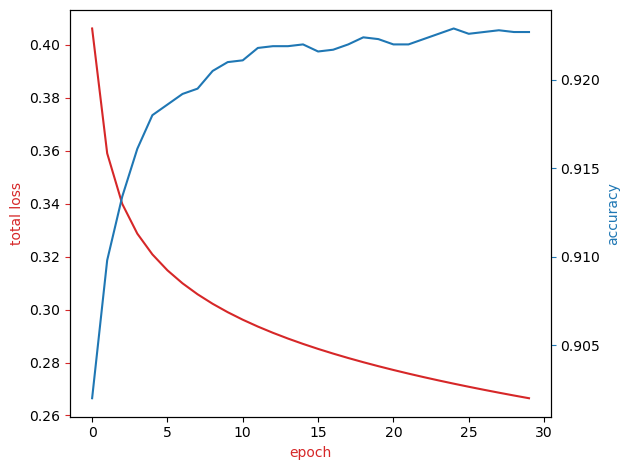

In [25]:
# Plot the loss and accuracy

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(loss_list,color=color)
ax1.set_xlabel('epoch',color=color)
ax1.set_ylabel('total loss',color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)  
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

## Plot the speed and accuracy

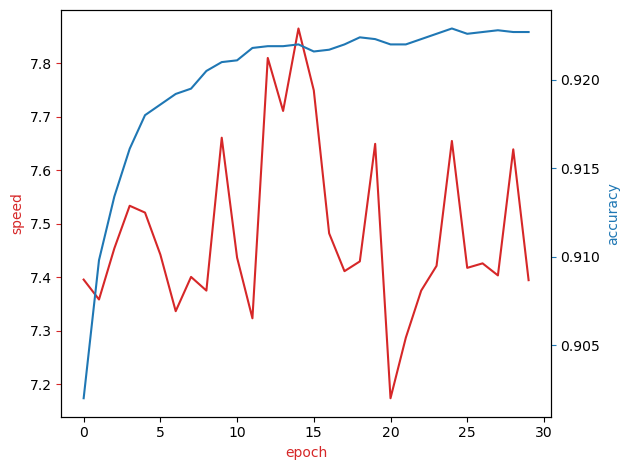

In [26]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(speed_list,color=color)
ax1.set_xlabel('epoch',color=color)
ax1.set_ylabel('speed',color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)  
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

## Plot memory and accuracy

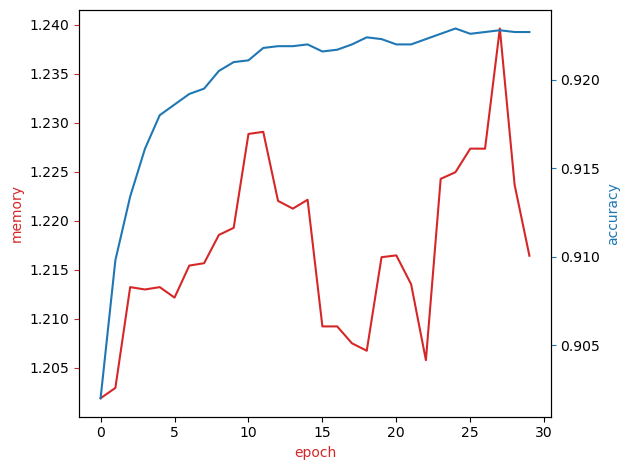

In [27]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(memory_list,color=color)
ax1.set_xlabel('epoch',color=color)
ax1.set_ylabel('memory',color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)  
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

## Test

### Before Quantization

In [29]:
model.eval()

SoftMax(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)

In [21]:
x_test=validation_dataset[0][0]
x_test=x_test.view(-1, 28*28)

In [30]:
model(x_test)

tensor([[-0.1147, -0.1358,  0.2424,  0.1902,  0.0136, -0.0225,  0.1155,  0.1053,
          0.2780, -0.0373]], grad_fn=<AddmmBackward0>)

### Quantazition 

In [23]:
quantized_model=torch.ao.quantization.quantize_dynamic(
    model,  # the original model
    {torch.nn.Linear},  # a set of layers to dynamically quantize
    dtype=torch.float16)  # the target dtype for quantized weights


In [24]:
# After quantization is applied by going from float32 to float16, the model performance has not changed
quantized_model(x_test)

tensor([[ 0.3506, -8.7347,  1.2183,  4.3100, -2.8958, -0.0288, -7.5294, 10.3447,
         -0.2021,  2.7964]], grad_fn=<AddBackward0>)

In [25]:

#to fix: I was traying to get the size of the float16 model with this function
def get_model_size_f16(model):
    params = np.sum(p.numel() for p in model.parameters())
    print("pparams:",params)
    size_bytes = params * 2  # Assuming float16 parameters (2 bytes per parameter)
    print(f"size_bytes:{size_bytes}")
    size_MB = size_bytes / (1024 ** 2)  # Convert to MB
    
    return size_MB

In [1]:
# Here too
def get_parameter_element_size(model):
    total_size_bytes = 0

    for param in model.parameters():
        element_size = param.element_size()
        total_size_bytes += element_size

    return total_size_bytes

In [27]:
get_parameter_element_size(quantized_model)

0

In [35]:
model_size_1 = get_model_size_f16(quantized_model)
print(f"Quantized Model Size: {model_size_1:.10f} MB")

pparams: 0
size_bytes:0
Quantized Model Size: 0.0000000000 MB


/tmp/ipykernel_32/2824535828.py:3: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  params = np.sum(p.numel() for p in model.parameters())


## Trying to create a float16 version of the model from scratch and see if I can get the correct size (to be fixed)

In [40]:
# create float16 model
class SoftMaxFloat16(nn.Module):
    # Constructor
    def __init__(self, input_dim, output_dim):
        super(SoftMaxFloat16, self).__init__()
        # Creates a layer of given input size and output size with float16 data type
        self.linear = nn.Linear(input_dim, output_dim).to(dtype=torch.float16)
        
    # Prediction
    def forward(self, x):
        # Runs the x value through the single layers defined above
        z = self.linear(x)
        return z

In [41]:
model_float16 = SoftMaxFloat16(input_dim, output_dim)

In [42]:
model_size_1 = get_model_size_f16(model_float16)
print(f"Quantized Model Size: {model_size_1:.10f} MB")

pparams: 7850
size_bytes:15700
Quantized Model Size: 0.0149726868 MB


/tmp/ipykernel_32/2824535828.py:3: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  params = np.sum(p.numel() for p in model.parameters())


## I could get the size above(reduced by 2), but then the dtype on the training libs don't match...

In [43]:
n_epochs = 10
# Lists to keep track of loss and accuracy
loss_list = []
accuracy_list = []
# Size of the validation data
N_test = len(validation_dataset)

#monitor memory usage
peak_gpu_memory_used =0
cpu_memory_used=0
# Function to train the model based on number of epochs
def train_model_16(n_epochs):
    # Loops n_epochs times
    for epoch in range(n_epochs):
        start_time = time.time()
        # For each batch in the train loader
        for x, y in train_loader:
            # Resets the calculated gradient value, this must be done each time as it accumulates if we do not reset
            optimizer.zero_grad()
            # Makes a prediction based on the image tensor
            z = model_float16(x.view(-1, 28 * 28))
            # Calculates loss between the model output and actual class
            loss = criterion(z, y)
            # Calculates the gradient value with respect to each weight and bias
            loss.backward()
            # Updates the weight and bias according to calculated gradient value
            optimizer.step()
        
        # Each epoch we check how the model performs with data it has not seen which is the validation data, we are not training here
        correct = 0
        # For each batch in the validation loader
        for x_test, y_test in validation_loader:
            # Makes prediction based on image tensor
            z = model_float16(x_test.view(-1, 28 * 28)) #MUST CHANGE DATA TYPE EVERYWHERE
            # Finds the class with the higest output
            _, yhat = torch.max(z.data, 1)
            # Checks if the prediction matches the actual class and increments correct if it does
            correct += (yhat == y_test).sum().item()
        # Calculates the accuracy by dividing correct by size of validation dataset
        accuracy = correct / N_test
        # Keeps track loss
        loss_list.append(loss.data)
        # Keeps track of the accuracy
        accuracy_list.append(accuracy)
        peak_gpu_memory_used= torch.cuda.max_memory_allocated()/ (1024 ** 3)
        cpu_memory_used = psutil.virtual_memory().used / (1024 ** 3)
        end_time = time.time()
        epoch_time = end_time - start_time

        print(f"Epoch {epoch+1}/{n_epochs} - Time: {epoch_time:.2f} seconds")
        print(f"Accuracy : {accuracy}")
        print()
        
#     print(f"Peak GPU Memory Used: {peak_gpu_memory_used:.2f} GB")
    print(f"CPU Memory Used: {cpu_memory_used:.2f} GB")

# Function call
train_model_16(n_epochs)

RuntimeError: mat1 and mat2 must have the same dtype